# Introduction

The aim of this notebook is to stress the Raspberry Pi 4 for deciding between different cases and cooling types.

Sources:

- [https://github.com/nschloe/stressberry](https://github.com/nschloe/stressberry)
- [https://www.pragmaticlinux.com/2020/06/check-the-raspberry-pi-cpu-temperature/](https://www.pragmaticlinux.com/2020/06/check-the-raspberry-pi-cpu-temperature/)
- [https://www.raspberrypi.org/blog/thermal-testing-raspberry-pi-4/](https://www.raspberrypi.org/blog/thermal-testing-raspberry-pi-4/)
- [http://blog.juliusschulz.de/blog/ultimate-ipython-notebook](http://blog.juliusschulz.de/blog/ultimate-ipython-notebook)

## Load globally used libraries and set plot parameters

In [2]:
import subprocess
import os
import threading
import time
import copy

import smbus2
import bme280

import pandas as pd
import numpy as np
import prettytable as pt

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

# FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. 
# The converter was registered by pandas on import. 
# Future versions of pandas will require you to explicitly register matplotlib converters.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')

plt.rcParams['savefig.dpi'] = 80
plt.rcParams['savefig.bbox'] = "tight"

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

# Need to install dependent package first via 'apt install cm-super'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"

/home/bk/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


# Define all cooling and ventilation scenarios

The following cooling and ventilation scenarios are to be tested and measured for the **Raspberry Pi B4**. For the assignment of the experimental setups, the unique scenario IDs are in parentheses.

## Raspberry Pi B4: Passive cooling (without fan)

### Without heat sinks

- with well ventilated case ***(scen_id_01)***
    
### With aluminum heat sinks

- thermal coupling: double-sided thermal tape
    - well ventilated case ***(scen_id_02)***
    - tightly closed pink Raspberry Pi case ***(scen_id_03)***
- thermal coupling: silicone pads
    - well ventilated case ***(scen_id_04)***

### With copper heat sink (CPU)

- thermal coupling: silicone pad
    - well ventilated case ***(scen_id_05)***

## Raspberry Pi B4: Active cooling (with fan)

### With aluminum heat sinks

- thermal coupling: double-sided thermal tape in well-ventilated case
    - with cheap, noisy fan
        - fast speed via 5 V connection
            - blowing onto heat sink ***(scen_id_06)***
            - blowing away from heat sink ***(scen_id_07)***
        - slow speed via 3.3 V connection
            - blowing onto heat sink ***(scen_id_08)***
    - with high-quality, low-noise Noctua fan
        - fast speed via 5 V connection
            - blowing onto heat sink ***(scen_id_09)***
            - blowing away from heat sink ***(scen_id_10)***
        - slow speed via 3.3 V connection
            - blowing onto heat sink ***(scen_id_11)***
- thermal coupling: silicone pads
    - well ventilated case (not carried out, as no new findings were expected)

### With copper heat sink (CPU)

- thermal coupling: silicone pad in well ventilated case
    - with high-quality, low-noise Noctua fan
        - slow speed via 3.3 V connection
            - blowing onto heat sink ***(scen_id_12)***

### With very large aluminum heatsink

- thermal coupling: silicone pads without enclosing case
    - fan controlled by GPIO (two-point controller: switch-off temperature approx. 10 K below switch-on temperature)
        - switch-on temperature 70 °C ***(scen_id_13)***
        - Switch-on temperature 65 °C ***(scen_id_14)***

### With very large aluminum heatsink and heat pipe (ICE Tower)

- thermal coupling: silicone pads without enclosing case
    - fast speed via 5 V connection
        - blowing onto heat sink ***(scen_id_15)***
    - slow speed via 3.3 V connection
        - blowing onto heat sink ***(scen_id_16)***

## Raspberry Pi B3+: Passive cooling (without fan):

As a comparison, the following cooling scenario will be measured for the **Raspberry Pi B3+**.

### With aluminum heat sinks

- thermal coupling: double-sided thermal tape
    - well ventilated case ***(scen_id_17)***

## Implementation of all scenarios in a central dataframe and dictionaries

### Central dataframe for all scenarios

All previously defined scenarios are organized in this central dataframe.

In [3]:
df_measurement_configs = pd.DataFrame(columns=
    ['Scenario IDs', 'Measurement platform', 'Dataframe, CSV/Image suffixes', 'Diagramm description'],
                                      data=[
    ['scen_id_01', 'RaspiB4JupyterLab', '_plasticCase_woHeatSinks_woThermalTape_woFan', 'RPi4, Plastic Case without heat sinks or fan'],
    ['scen_id_02', 'RaspiB4JupyterLab', '_plasticCase_wAluHeatSinks_thermalTape_woFan', 'R4, Plastic Case with glued-on aluminum heat sinks by thermal tape, without fan'],
    ['scen_id_03', 'RaspiB4JupyterLab', '_pinkRaspiCase_wAluHeatSinks_thermalTape_woFan', 'R4, Pink Raspi Case with glued-on aluminum heat sinks by thermal tape, without fan'],
    ['scen_id_04', 'RaspiB4JupyterLab', '_plasticCase_wAluHeatSinks_siliconPads_woFan', 'R4, Plastic Case with glued-on aluminum heat sinks by silicone pads, without fan'],
    ['scen_id_05', 'RaspiB4JupyterLab', '_plasticCase_wCopperHeatSink_siliconPads_woFan', 'R4, Plastic Case with glued-on copper heat sink by silicone pad, without fan'],
    ['scen_id_06', 'RaspiB4JupyterLab', '_plasticCase_wAluHeatSinks_thermalTape_wFan5V', 'R4, Plastic Case with glued-on aluminum heat sinks by thermal tape, with fan (5 V)'],
    ['scen_id_07', 'RaspiB4JupyterLab', '_plasticCase_wAluHeatSinks_thermalTape_wFan5Vrev', 'R4, Plastic Case with glued-on aluminum heat sinks by thermal tape, with fan reverted (5 V)'],
    ['scen_id_08', 'RaspiB4JupyterLab', '_plasticCase_wAluHeatSinks_thermalTape_wFan3V', 'R4, Plastic Case with glued-on aluminum heat sinks by thermal tape, with fan (3.3 V)'],
    ['scen_id_09', 'RaspiB4JupyterLab', '_plasticCase_wAluHeatSinks_thermalTape_wNoctuaFan5V', 'R4, Plastic Case with glued-on aluminum heat sinks by thermal tape, with Noctua fan (5 V)'],
    ['scen_id_10', 'RaspiB4JupyterLab', '_plasticCase_wAluHeatSinks_thermalTape_wNoctuaFan5Vrev', 'R4, Plastic Case with glued-on aluminum heat sinks by thermal tape, with Noctua fan reverted (5 V)'],
    ['scen_id_11', 'RaspiB4JupyterLab', '_plasticCase_wAluHeatSinks_thermalTape_wNoctuaFan3V', 'R4, Plastic Case with glued-on aluminum heat sinks by thermal tape, with Noctua fan (3.3 V)'],
    ['scen_id_12', 'RaspiB4JupyterLab', '_plasticCase_wCopperHeatSink_siliconPad_wNoctuaFan3V', 'R4, Plastic Case with glued-on copper heat sink by silicone pad, with Noctua fan (3.3 V)'],
    ['scen_id_13', 'RaspiB4JupyterLab', '_woCase_wBigAluHeatSink_siliconPads_CtrlFan70C', 'R4, Without Case with large aluminum heat sink, glued-on by silicone pads, with ctrl fan (switch-on: 70 °C)'],
    ['scen_id_14', 'RaspiB4JupyterLab', '_woCase_wBigAluHeatSink_siliconPads_CtrlFan65C', 'R4, Without Case with large aluminum heat sink, glued-on by silicone pads, with ctrl fan (switch-on: 65 °C)'],
    ['scen_id_15', 'RaspiB4JupyterLab', '_woCase_wAluCopperHeatPipes_siliconPads_wFan5V', 'R4, Without Case with large aluminum heat sink and copper heat pipes, glued-on by silicone pads, with fan (5 V)'],
    ['scen_id_16', 'RaspiB4JupyterLab', '_woCase_wAluCopperHeatPipes_siliconPads_wFan3V', 'R4, Without Case with large aluminum heat sink and copper heat pipes, glued-on by silicone pads, with fan (3.3 V)'],
    ['scen_id_17', 'RaspiB3plusEPaper', '_plasticCase_wAluHeatSinks_thermalTape_woFan', 'R3+, Plastic Case with glued-on aluminum heat sinks by thermal tape, without fan']
                                     ])

display(df_measurement_configs)

Scenario IDs Measurement platform  \
0    scen_id_01    RaspiB4JupyterLab   
1    scen_id_02    RaspiB4JupyterLab   
2    scen_id_03    RaspiB4JupyterLab   
3    scen_id_04    RaspiB4JupyterLab   
4    scen_id_05    RaspiB4JupyterLab   
5    scen_id_06    RaspiB4JupyterLab   
6    scen_id_07    RaspiB4JupyterLab   
7    scen_id_08    RaspiB4JupyterLab   
8    scen_id_09    RaspiB4JupyterLab   
9    scen_id_10    RaspiB4JupyterLab   
10   scen_id_11    RaspiB4JupyterLab   
11   scen_id_12    RaspiB4JupyterLab   
12   scen_id_13    RaspiB4JupyterLab   
13   scen_id_14    RaspiB4JupyterLab   
14   scen_id_15    RaspiB4JupyterLab   
15   scen_id_16    RaspiB4JupyterLab   
16   scen_id_17    RaspiB3plusEPaper   

                        Dataframe, CSV/Image suffixes  \
0        _plasticCase_woHeatSinks_woThermalTape_woFan   
1        _plasticCase_wAluHeatSinks_thermalTape_woFan   
2      _pinkRaspiCase_wAluHeatSinks_thermalTape_woFan   
3        _plasticCase_wAluHeatSinks_siliconPads_woFan   
4      _plasticCase_wCopperHeatSink_siliconPads_woFan   
5       _plasticCase_wAluHeatSinks_thermalTape_wFan5V   
6    _plasticCase_wAluHeatSinks_thermalTape_wFan5Vrev   
7       _plasticCase_wAluHeatSinks_thermalTape_wFan3V   
8   _plasticCase_wAluHeatSinks_thermalTape_wNoctua...   
9   _plasticCase_wAluHeatSinks_thermalTape_wNoctua...   
10  _plasticCase_wAluHeatSinks_thermalTape_wNoctua...   
11  _plasticCase_wCopperHeatSink_siliconPad_wNoctu...   
12     _woCase_wBigAluHeatSink_siliconPads_CtrlFan70C   
13     _woCase_wBigAluHeatSink_siliconPads_CtrlFan65C   
14     _woCase_wAluCopperHeatPipes_siliconPads_wFan5V   
15     _woCase_wAluCopperHeatPipes_siliconPads_wFan3V   
16       _plasticCase_wAluHeatSinks_thermalTape_woFan   

                                 Diagramm description  
0        RPi4, Plastic Case without heat sinks or fan  
1   R4, Plastic Case with glued-on aluminum heat s...  
2   R4, Pink Raspi Case with glued-on aluminum hea...  
3   R4, Plastic Case with glued-on aluminum heat s...  
4   R4, Plastic Case with glued-on copper heat sin...  
5   R4, Plastic Case with glued-on aluminum heat s...  
6   R4, Plastic Case with glued-on aluminum heat s...  
7   R4, Plastic Case with glued-on aluminum heat s...  
8   R4, Plastic Case with glued-on aluminum heat s...  
9   R4, Plastic Case with glued-on aluminum heat s...  
10  R4, Plastic Case with glued-on aluminum heat s...  
11  R4, Plastic Case with glued-on copper heat sin...  
12  R4, Without Case with large aluminum heat sink...  
13  R4, Without Case with large aluminum heat sink...  
14  R4, Without Case with large aluminum heat sink...  
15  R4, Without Case with large aluminum heat sink...  
16  R3+, Plastic Case with glued-on aluminum heat ...

### Dynamically create dataframes for the scenarios

This function dynamically creates empty dataframes with speaking names for the scenarios and stores them in a dictionary for further access. These dataframes are to be filled later with the recorded measuring data.

In [4]:
# Create new dataframes in pandas with dynamic names
# Found here: https://stackoverflow.com/questions/40973687/create-new-dataframe-in-pandas-with-dynamic-names-also-add-new-column/40974699#40974699

# Extract column value based on another column from pandas dataframe
# Found here: https://stackoverflow.com/questions/36684013/extract-column-value-based-on-another-column-pandas-dataframe/36685531#36685531

def create_dict_of_df_for_measurement_records(df=None):

    _dict_of_df = {}
    _df_empty = {}

    for _df_scen_ids in df['Scenario IDs']:
        _df_suffix_str = df.loc[df['Scenario IDs'] == _df_scen_ids, 'Dataframe, CSV/Image suffixes'].iloc[0]
        #print(_df_suffix_str)

        _new_df_name_str = 'df_'+str(_df_scen_ids)+str(_df_suffix_str)
        #print(_new_df_name_str)

        _dict_of_df[_new_df_name_str] = copy.deepcopy(_df_empty)
        
    return _dict_of_df

In [9]:
dict_of_df_records = create_dict_of_df_for_measurement_records(df_measurement_configs)

display(dict_of_df_records)

{'df_scen_id_01_plasticCase_woHeatSinks_woThermalTape_woFan': {},
 'df_scen_id_02_plasticCase_wAluHeatSinks_thermalTape_woFan': {},
 'df_scen_id_03_pinkRaspiCase_wAluHeatSinks_thermalTape_woFan': {},
 'df_scen_id_04_plasticCase_wAluHeatSinks_siliconPads_woFan': {},
 'df_scen_id_05_plasticCase_wCopperHeatSink_siliconPads_woFan': {},
 'df_scen_id_06_plasticCase_wAluHeatSinks_thermalTape_wFan5V': {},
 'df_scen_id_07_plasticCase_wAluHeatSinks_thermalTape_wFan5Vrev': {},
 'df_scen_id_08_plasticCase_wAluHeatSinks_thermalTape_wFan3V': {},
 'df_scen_id_09_plasticCase_wAluHeatSinks_thermalTape_wNoctuaFan5V': {},
 'df_scen_id_10_plasticCase_wAluHeatSinks_thermalTape_wNoctuaFan5Vrev': {},
 'df_scen_id_11_plasticCase_wAluHeatSinks_thermalTape_wNoctuaFan3V': {},
 'df_scen_id_12_plasticCase_wCopperHeatSink_siliconPad_wNoctuaFan3V': {},
 'df_scen_id_13_woCase_wBigAluHeatSink_siliconPads_CtrlFan70C': {},
 'df_scen_id_14_woCase_wBigAluHeatSink_siliconPads_CtrlFan65C': {},
 'df_scen_id_15_woCase_wAluCop

### Create dictionary with filenames for all scenarios

This function creates a dictionary with speaking filenames used for storing the recorded measuring data in CSV files and for storing the plotted diagrams in PDF files.

In [5]:
# Extract column value based on another column from pandas dataframe
# Found here: https://stackoverflow.com/questions/36684013/extract-column-value-based-on-another-column-pandas-dataframe/36685531#36685531

def create_filenames_for_measurement_records(df=None):

    _dict_of_filenames = {}

    for _df_scen_ids in df['Scenario IDs']:
        _platform_str = df.loc[df['Scenario IDs'] == _df_scen_ids, 'Measurement platform'].iloc[0]
        #print(_platform_str)
        
        _filename_suffix_str = df.loc[df['Scenario IDs'] == _df_scen_ids, 'Dataframe, CSV/Image suffixes'].iloc[0]
        #print(_filename_suffix_str)

        _new_filename_str = str(_df_scen_ids)+'_'+str(_platform_str)+str(_filename_suffix_str)
        #print(_new_filename_str)
        
        _dict_of_filenames[_df_scen_ids] = _new_filename_str
        
    return _dict_of_filenames

In [10]:
dict_of_filenames = create_filenames_for_measurement_records(df_measurement_configs)

display(dict_of_filenames)

{'scen_id_01': 'scen_id_01_RaspiB4JupyterLab_plasticCase_woHeatSinks_woThermalTape_woFan',
 'scen_id_02': 'scen_id_02_RaspiB4JupyterLab_plasticCase_wAluHeatSinks_thermalTape_woFan',
 'scen_id_03': 'scen_id_03_RaspiB4JupyterLab_pinkRaspiCase_wAluHeatSinks_thermalTape_woFan',
 'scen_id_04': 'scen_id_04_RaspiB4JupyterLab_plasticCase_wAluHeatSinks_siliconPads_woFan',
 'scen_id_05': 'scen_id_05_RaspiB4JupyterLab_plasticCase_wCopperHeatSink_siliconPads_woFan',
 'scen_id_06': 'scen_id_06_RaspiB4JupyterLab_plasticCase_wAluHeatSinks_thermalTape_wFan5V',
 'scen_id_07': 'scen_id_07_RaspiB4JupyterLab_plasticCase_wAluHeatSinks_thermalTape_wFan5Vrev',
 'scen_id_08': 'scen_id_08_RaspiB4JupyterLab_plasticCase_wAluHeatSinks_thermalTape_wFan3V',
 'scen_id_09': 'scen_id_09_RaspiB4JupyterLab_plasticCase_wAluHeatSinks_thermalTape_wNoctuaFan5V',
 'scen_id_10': 'scen_id_10_RaspiB4JupyterLab_plasticCase_wAluHeatSinks_thermalTape_wNoctuaFan5Vrev',
 'scen_id_11': 'scen_id_11_RaspiB4JupyterLab_plasticCase_wAluHe

# Implementation of helper functions

## Variant 1: Function for reading the CPU core temperature

This implementation retrieves the temperature information from the system file `/sys/class/thermal/thermal_zone0/temp`.

In [2]:
# Function for reading the CPU core temperature
# Found here: https://www.pragmaticlinux.com/2020/06/check-the-raspberry-pi-cpu-temperature/
def get_cpu_temp_old():
    """
    Obtains the current value of the CPU temperature.
    :returns: Current value of the CPU temperature if successful, zero value otherwise.
    :rtype: float
    """
    # Initialize the result.
    result = 0.0
    # The first line in this file holds the CPU temperature as an integer times 1000.
    # Read the first line and remove the newline character at the end of the string.
    if os.path.isfile('/sys/class/thermal/thermal_zone0/temp'):
        with open('/sys/class/thermal/thermal_zone0/temp') as f:
            line = f.readline().strip()
        # Test if the string is an integer as expected.
        if line.isdigit():
            # Convert the string with the CPU temperature to a float in degrees Celsius.
            result = float(line) / 1000
    # Give the result back to the caller.
    return result

## Variant 2: Function for reading the CPU core temperature (used here)

This implementation retrieves the temperature information from the command line tool `vcgencmd`. In the bash console you can get the same result by issuing:
```bash
$ vcgencmd measure_temp
```

In [3]:
# Function for reading the CPU core temperature
# Found here: https://github.com/nschloe/stressberry/blob/main/stressberry/main.py
def get_cpu_temp(filename=None):
    """Returns the core temperature in Celsius."""
    if filename is not None:
        with open(filename) as f:
            temp = float(f.read()) / 1000
    else:
        # Using vcgencmd is specific to the raspberry pi
        out = subprocess.check_output(["vcgencmd", "measure_temp"]).decode("utf-8")
        temp = float(out.replace("temp=", "").replace("'C", ""))
    
    return temp

## Function for reading the CPU core frequency

The frequency information is retrieved from the command line tool `vcgencmd` also. In the bash console you can get the same result by issuing:
```bash
$ vcgencmd measure_clock arm
```

Issue regarding the **Raspberry Pi 3B+** (2021-06-01):  
With the latest Raspbian updates there seems to be a bug in reading the CPU frequency with the otherwise propagated command line call ```vcgencmd measure_clock arm```. With this call only frequencies around 600 MHz are displayed even under full load of the CPU. The direct query of the ```/sys``` device tree provides the correct results for the first core:
```bash
$ cat /sys/devices/system/cpu/cpu0/cpufreq/scaling_cur_freq
```
Therefore, the function has been extended to first query which Raspberry Pi hardware is present. If it is a **RPi 3B+**, the current CPU frequency is queried directly from the device tree instead of via the ```vcgencmd``` tools.

In [4]:
# Function for reading the CPU core frequency
def get_cpu_freq(filename=None):
    if os.path.isfile('/sys/firmware/devicetree/base/model'):
        with open('/sys/firmware/devicetree/base/model') as f:
            hw_version = f.readline().strip()
    
    # RPi 3B+: there seems to be a bug in reading CPU frequency with 'vcgencmd'
    if (hw_version.startswith('Raspberry Pi 3 Model B Plus')):
        if os.path.isfile('/sys/devices/system/cpu/cpu0/cpufreq/scaling_cur_freq'):
            with open('/sys/devices/system/cpu/cpu0/cpufreq/scaling_cur_freq') as f:
                line = f.readline().strip()
            # Test if the string is an integer as expected.
            if line.isdigit():
                # Convert the string with the CPU frequency to a float in MHz.
                frequency = float(line) / 1000
    # RPi 4B: 'vcgencmd' does work as expected ...
    else:
        """Returns the CPU frequency in MHz"""
        if filename is not None:
            with open(filename) as f:
                frequency = float(f.read()) / 1000
        else:
            # Only vcgencmd measure_clock arm is accurate on Raspberry Pi.
            # Per: https://www.raspberrypi.org/forums/viewtopic.php?f=63&t=219358&start=25
            out = subprocess.check_output(["vcgencmd", "measure_clock arm"]).decode("utf-8")
            frequency = float(out.split("=")[1]) / 1000000
    
    return frequency

## Function for reading the ambient temperature

In order to compare the recorded CPU core temperatures of the different housing and cooling scenarios, the temperature curves must be normalized with the curves of the simultaneously measured ambient temperature.  
However, only the curves of the so-called "overtemperature" are comparable, which is the difference between the curves of the CPU core temperature and the ambient temperature.

The external Bosch sensor *BME280* is used to measure the ambient temperature. This is connected to the Raspberry Pi via a USB-I2C adapter. The installation of the required kernel module is described in the Jupyter notebook [BME280.ipynb](./BME280.ipynb).

In [5]:
# i2c bus on /dev/i2c-11
port = 11
# i2c address of BME280
address = 0x76
bus = smbus2.SMBus(port)

# Function for reading the ambient temperature
# Found here: https://github.com/nschloe/stressberry/blob/main/stressberry/main.py
def get_ambient_temp():
    """Returns the ambient temperature in Celsius."""
    
    calibration_params = bme280.load_calibration_params(bus, address)

    # the sample method will take a single reading and return
    # a compensated_reading object
    data_obj = bme280.sample(bus, address, calibration_params)
    
    return data_obj.temperature

## Helper functions for stressing all cores of the CPU

Stress is created by the command line tool `stress`. It has to be installed first by issuing:
```bash
$ sudo apt install stress
```

In [6]:
# Helper function to call the 'stress' command line tool
def stress_cpu(num_cpus, time):
    subprocess.check_call(["stress", "--cpu", str(num_cpus), "--timeout", f"{time}s"])
    return

In [7]:
# Function for stressing all cores of the CPU
# Found here: https://github.com/nschloe/stressberry/blob/main/stressberry/main.py
def run_stress(stress_duration=300, idle_duration=120, cores=None):
    """Run stress test for specified duration with specified idle times
    at the start and end of the test.
    """
    if cores is None:
        cores = os.cpu_count()

    print(f"Preparing to stress [{cores}] CPU Cores for [{stress_duration}] seconds")
    print(f"Idling for {idle_duration} seconds...")
    time.sleep(idle_duration)

    print(f"Starting the stress load on [{cores}] CPU Cores for [{stress_duration}] seconds")
    stress_cpu(num_cpus=cores, time=stress_duration)

    print(f"Idling for {idle_duration} seconds...")
    time.sleep(idle_duration)

## Helper function to let the CPU cool down

This function is used to let the CPU cool down first to find a stable baseline.

In [8]:
def cpu_cooldown(interval=60, filename=None):
    """Lets the CPU cool down until the temperature does not change anymore."""
    prev_tmp = get_cpu_temp()
    while True:
        time.sleep(interval)
        tmp = get_cpu_temp()
        print(
            f"Current temperature: {tmp:4.1f}°C - "
            f"Previous temperature: {prev_tmp:4.1f}°C"
        )
        if abs(tmp - prev_tmp) < 0.2:
            break
        prev_tmp = tmp
    return tmp

## Helper function for handling dataframes

First, a dataframe is created and at the same time the column headers are set. The function ```dataframe_add_row()``` is used to add the measured values to the dataframe in the form of new rows.

In [9]:
# Dataframe for the measuring values
df_meas_values = pd.DataFrame(columns=['Time', 'CPU Temperature', 'CPU Frequency', 'Ambient Temperature'])

In [37]:
def dataframe_add_row(df=None, row=[]):
    if (df is None):
        return
    
    # Add a row
    df.loc[-1] = row
    
    # Shift the index
    df.index = df.index + 1
    
    # Reset the index of dataframe and avoid the old index being added as a column
    df.reset_index(drop=True, inplace=True)

## Main worker function

In [11]:
# Function for running the stress test in another thread while measuring CPU temperature and frequency
# Found here: https://github.com/nschloe/stressberry/blob/main/stressberry/cli/run.py
def run(argv=None):
    # Cool down first
    print("Awaiting stable baseline temperature ...")
    cpu_cooldown(interval=60)

    # Start the stress test in another thread
    t = threading.Thread(
        target=lambda: run_stress(stress_duration=900, idle_duration=300, cores=4), args=()
    )
    # Init event handler for killing the thread
    t.event = threading.Event()
    # Start the thread
    t.start()

    # Init row array
    values_row = []
    # Get starting time
    start_time = time.time()
    while t.is_alive():
        try:
            # Get time relative to starting time and round to 1 decimal
            timestamp = float("{:.1f}".format(time.time() - start_time))
            # Get CPU temperature and round to 1 decimal
            temperature_cpu = float("{:.1f}".format(get_cpu_temp()))
            # Get ambient temperature and round to 1 decimal
            temperature_ambient = float("{:.1f}".format(get_ambient_temp()))
            # Get CPU frequency and round to 1 decimal
            frequency = float("{:.1f}".format(get_cpu_freq()))

            values_row = [ timestamp,
                           temperature_cpu,
                           frequency,
                           temperature_ambient
                         ]

            dataframe_add_row(df_meas_values, values_row)

            print(
                    f"Time: {timestamp} s,\t"
                    f"CPU Temperature: {temperature_cpu} °C,\t"
                    f"Ambient Temperature: {temperature_ambient} °C,\t"
                    f"Frequency: {frequency} MHz"
                 )

            # Choose the sample interval such that we have a respectable number of data points
            t.join(2.0)
            
        except:
            print("Keyboard Interrupt ^C detected.")
            print("Bye.")
            # Stop the thread by calling the event
            t.event.set()
            break
        
    # Normalize times so we are starting at '0 s'
    #time0 = df_meas_values['Time'][0]
    # It's a really fancy oneliner - but not necessary at all ...
    #df_meas_values['Time'] = [tm - time0 for tm in df_meas_values['Time']]

# Run the heating test

In [ ]:
# Clear all data in dataframe
df_meas_values = df_meas_values.iloc[0:0]

run()

In [ ]:
display(df_meas_values)

# Save all to CSV files

Here you have to decide where (with indication of path and file name) the current measurement should be stored by uncommenting and commenting.

In [ ]:
str_path = r'./data_files/'

#str_current_screnario = 'scen_id_01' # scen_id_01_RaspiB4JupyterLab_plasticCase_woHeatSinks_woThermalTape_woFan
#str_current_screnario = 'scen_id_02' # scen_id_02_RaspiB4JupyterLab_plasticCase_wAluHeatSinks_thermalTape_woFan
#str_current_screnario = 'scen_id_03' # scen_id_03_RaspiB4JupyterLab_pinkRaspiCase_wAluHeatSinks_thermalTape_woFan
#str_current_screnario = 'scen_id_04' # scen_id_04_RaspiB4JupyterLab_plasticCase_wAluHeatSinks_siliconPads_woFan
#str_current_screnario = 'scen_id_05' # scen_id_05_RaspiB4JupyterLab_plasticCase_wCopperHeatSink_siliconPads_woFan
#str_current_screnario = 'scen_id_06' # scen_id_06_RaspiB4JupyterLab_plasticCase_wAluHeatSinks_thermalTape_wFan5V
#str_current_screnario = 'scen_id_07' # scen_id_07_RaspiB4JupyterLab_plasticCase_wAluHeatSinks_thermalTape_wFan5Vrev
#str_current_screnario = 'scen_id_08' # scen_id_08_RaspiB4JupyterLab_plasticCase_wAluHeatSinks_thermalTape_wFan3V
#str_current_screnario = 'scen_id_09' # scen_id_09_RaspiB4JupyterLab_plasticCase_wAluHeatSinks_thermalTape_wNoctuaFan5V
#str_current_screnario = 'scen_id_10' # scen_id_10_RaspiB4JupyterLab_plasticCase_wAluHeatSinks_thermalTape_wNoctuaFan5Vrev
#str_current_screnario = 'scen_id_11' # scen_id_11_RaspiB4JupyterLab_plasticCase_wAluHeatSinks_thermalTape_wNoctuaFan3V
str_current_screnario = 'scen_id_12' # scen_id_12_RaspiB4JupyterLab_plasticCase_wCopperHeatSink_siliconPad_wNoctuaFan3V
#str_current_screnario = 'scen_id_13' # scen_id_13_RaspiB4JupyterLab_woCase_wBigAluHeatSink_siliconPads_CtrlFan70C
#str_current_screnario = 'scen_id_14' # scen_id_14_RaspiB4JupyterLab_woCase_wBigAluHeatSink_siliconPads_CtrlFan65C
#str_current_screnario = 'scen_id_15' # scen_id_15_RaspiB4JupyterLab_woCase_wAluCopperHeatPipes_siliconPads_wFan5V
#str_current_screnario = 'scen_id_16' # scen_id_16_RaspiB4JupyterLab_woCase_wAluCopperHeatPipes_siliconPads_wFan3V
#str_current_screnario = 'scen_id_17' # scen_id_17_RaspiB3plusEPaper_plasticCase_wAluHeatSinks_thermalTape_woFan

#print(dict_of_filenames[str_current_screnario])
df_meas_values.to_csv(str_path + dict_of_filenames[str_current_screnario] +'.csv', sep ='\t', index = False, header=True)

# Read in the CSV files and plot the measurements

## Read in the CSV files in dataframes

This is a helper function for creating dataframes from CSV files.

In [6]:
def create_dictionary_from_csv(filename, offset=0, cols_wanted=1):
    my_dataframe = pd.read_csv(filename, sep='\t', index_col=False, decimal='.', header=offset)
    
    # Delete all cloumns after the desired ones
    my_dataframe.drop(my_dataframe.columns[cols_wanted:], axis=1, inplace=True)

    return my_dataframe

Here all existing (has to be proven first!) data record files are read in to the dictionary of record dataframes. For this purpose the scenario IDs are searched recursively in the dictionary of data records to get the dataframe names.

In [11]:
for scen_ids in dict_of_filenames:
    #print(dict_of_filenames[scen_ids])
    
    str_filepath = './data_files/' + dict_of_filenames[scen_ids] +'.csv'
    
    # Prove if filenames really exist!
    if os.path.isfile(str_filepath):
        # Search recursively in dictionary of data records with
        # the scenario IDs to get the dataframe names
        for df_names in dict_of_df_records:
            if scen_ids in df_names:
                #print(df_names)
                dict_of_df_records[df_names] = create_dictionary_from_csv(filename=str_filepath, offset=0, cols_wanted=4)

Whether all dataframes have been filled correctly is checked again here:

In [12]:
for df_names in dict_of_df_records:
    # Display only the filled dataframes
    if not len(dict_of_df_records[df_names]) == 0:
        print("Dataframe name: {}".format(df_names))
        display(dict_of_df_records[df_names].head(3))
        display(dict_of_df_records[df_names].dtypes)
        print('\n')

Dataframe name: df_scen_id_01_plasticCase_woHeatSinks_woThermalTape_woFan


Time  CPU Temperature  CPU Frequency  Ambient Temperature
0   0.0             49.1         1500.3                 20.2
1   2.1             48.7          800.2                 20.1
2   4.3             49.6          800.2                 20.1

Time                   float64
CPU Temperature        float64
CPU Frequency          float64
Ambient Temperature    float64
dtype: object



Dataframe name: df_scen_id_02_plasticCase_wAluHeatSinks_thermalTape_woFan


Time  CPU Temperature  CPU Frequency  Ambient Temperature
0   0.0             48.7         1500.3                 20.3
1   2.1             48.2          800.2                 20.4
2   4.3             47.2          900.2                 20.4

Time                   float64
CPU Temperature        float64
CPU Frequency          float64
Ambient Temperature    float64
dtype: object



Dataframe name: df_scen_id_03_pinkRaspiCase_wAluHeatSinks_thermalTape_woFan


Time  CPU Temperature  CPU Frequency  Ambient Temperature
0   0.0             49.6          900.2                 20.9
1   2.1             48.7         1000.3                 20.9
2   4.3             48.7         1000.3                 20.9

Time                   float64
CPU Temperature        float64
CPU Frequency          float64
Ambient Temperature    float64
dtype: object



Dataframe name: df_scen_id_04_plasticCase_wAluHeatSinks_siliconPads_woFan


Time  CPU Temperature  CPU Frequency  Ambient Temperature
0   0.0             51.6         1500.4                 23.6
1   2.1             52.5         1000.2                 23.6
2   4.3             52.1          800.2                 23.6

Time                   float64
CPU Temperature        float64
CPU Frequency          float64
Ambient Temperature    float64
dtype: object



Dataframe name: df_scen_id_05_plasticCase_wCopperHeatSink_siliconPads_woFan


Time  CPU Temperature  CPU Frequency  Ambient Temperature
0   0.0             53.5         1000.3                 24.0
1   2.1             52.1          900.2                 24.0
2   4.3             53.5          900.2                 24.0

Time                   float64
CPU Temperature        float64
CPU Frequency          float64
Ambient Temperature    float64
dtype: object



Dataframe name: df_scen_id_06_plasticCase_wAluHeatSinks_thermalTape_wFan5V


Time  CPU Temperature  CPU Frequency
0   0.0             30.6          900.2
1   2.1             29.2          800.2
2   4.2             29.7          900.2

Time               float64
CPU Temperature    float64
CPU Frequency      float64
dtype: object



Dataframe name: df_scen_id_07_plasticCase_wAluHeatSinks_thermalTape_wFan5Vrev


Time  CPU Temperature  CPU Frequency
0   0.0             36.5         1500.3
1   2.1             36.0          700.2
2   4.2             37.4         1500.4

Time               float64
CPU Temperature    float64
CPU Frequency      float64
dtype: object



Dataframe name: df_scen_id_08_plasticCase_wAluHeatSinks_thermalTape_wFan3V


Time  CPU Temperature  CPU Frequency
0   0.0             34.5         1000.3
1   2.1             35.0          900.2
2   4.2             35.0          900.2

Time               float64
CPU Temperature    float64
CPU Frequency      float64
dtype: object



Dataframe name: df_scen_id_09_plasticCase_wAluHeatSinks_thermalTape_wNoctuaFan5V


Time  CPU Temperature  CPU Frequency  Ambient Temperature
0   0.0             28.7         1000.2                 20.6
1   2.1             29.7          900.2                 20.6
2   4.3             30.6          900.2                 20.6

Time                   float64
CPU Temperature        float64
CPU Frequency          float64
Ambient Temperature    float64
dtype: object



Dataframe name: df_scen_id_10_plasticCase_wAluHeatSinks_thermalTape_wNoctuaFan5Vrev


Time  CPU Temperature  CPU Frequency  Ambient Temperature
0   0.0             33.6         1000.3                 20.7
1   2.1             33.1          800.2                 20.7
2   4.3             32.6         1000.2                 20.7

Time                   float64
CPU Temperature        float64
CPU Frequency          float64
Ambient Temperature    float64
dtype: object



Dataframe name: df_scen_id_11_plasticCase_wAluHeatSinks_thermalTape_wNoctuaFan3V


Time  CPU Temperature  CPU Frequency  Ambient Temperature
0   0.0             31.6          900.2                 20.4
1   2.1             32.1          900.2                 20.4
2   4.3             32.6         1000.2                 20.4

Time                   float64
CPU Temperature        float64
CPU Frequency          float64
Ambient Temperature    float64
dtype: object



Dataframe name: df_scen_id_12_plasticCase_wCopperHeatSink_siliconPad_wNoctuaFan3V


Time  CPU Temperature  CPU Frequency  Ambient Temperature
0   0.0             35.5         1000.2                 24.3
1   2.1             35.5         1000.2                 24.3
2   4.3             35.5          800.2                 24.3

Time                   float64
CPU Temperature        float64
CPU Frequency          float64
Ambient Temperature    float64
dtype: object



Dataframe name: df_scen_id_13_woCase_wBigAluHeatSink_siliconPads_CtrlFan70C


Time  CPU Temperature  CPU Frequency  Ambient Temperature
0   0.0             48.2         1000.3                 20.3
1   2.1             47.7         1000.3                 20.3
2   4.3             48.2          700.2                 20.3

Time                   float64
CPU Temperature        float64
CPU Frequency          float64
Ambient Temperature    float64
dtype: object



Dataframe name: df_scen_id_14_woCase_wBigAluHeatSink_siliconPads_CtrlFan65C


Time  CPU Temperature  CPU Frequency  Ambient Temperature
0   0.0             45.7          900.2                 24.6
1   2.1             45.7          700.2                 24.6
2   4.3             46.2          900.2                 24.5

Time                   float64
CPU Temperature        float64
CPU Frequency          float64
Ambient Temperature    float64
dtype: object



Dataframe name: df_scen_id_17_plasticCase_wAluHeatSinks_thermalTape_woFan


Time  CPU Temperature  CPU Frequency  Ambient Temperature
0   0.0             47.8          800.0                 23.2
1   2.2             47.8          800.0                 23.2
2   4.3             47.8          800.0                 23.2

Time                   float64
CPU Temperature        float64
CPU Frequency          float64
Ambient Temperature    float64
dtype: object

## Smoothing with a moving average filter

Here the column of the CPU temperature is smoothed a bit by a moving average filter:

In [13]:
i_avg_window = 6

for df_names in dict_of_df_records:
    # Smoothe only the filled dataframes
    if not len(dict_of_df_records[df_names]) == 0:
        #print("Dataframe name: {}".format(df_names))
        #display(dict_of_df_records[df_names].head(3))
        dict_of_df_records[df_names]['CPU Temperature'] = dict_of_df_records[df_names]['CPU Temperature'].rolling(window=i_avg_window).mean()

## Helper functions for plotting the single measurements

This function retrieves all necessary data and metainformation for plotting: the **diagramm title**, the **file path** and **name** for storing the diagram plot and the handle to the dataframe holding the **recorded data**.

In [67]:
def get_data_and_meta_infos_for_plotting(str_scen_id, df_measurement_configs=None, dict_of_df_records=None, dict_of_filenames=None):    
    _str_description = df_measurement_configs.loc[df_measurement_configs['Scenario IDs'] == str_scen_id, 'Diagramm description'].iloc[0]
    
    if dict_of_filenames is not None:
        _str_filepath = r'./data_files/' + dict_of_filenames[str_scen_id]
    else:
        _str_filepath = ''
    
    # Search recursively in dictionary of data records with
    # the scenario IDs to get the dataframe names
    for df_names in dict_of_df_records:
        if str_scen_id in df_names:
            _df_handle = dict_of_df_records[df_names]
    
    #print(_str_description)
    #print(_str_filepath)
    #display(_df_handle.head(3))
    
    return _df_handle, _str_description, _str_filepath

This function is used to plot the CPU temperature, the CPU frequency and the ambient temperature from a single measurement.

In [43]:
# Function for plotting the single measurements
def plot_single_measurement(str_scen_id):
    """Plot the CPU temperature, the CPU frequency and 
    the ambient temperature from a single measurement.
    """
    # Retrieve all necessary data
    _df_handle, _str_title, _str_filepath = get_data_and_meta_infos_for_plotting(str_scen_id, df_measurement_configs, dict_of_df_records, dict_of_filenames)

    # Figsize: a tuple (width, height) in inches
    # Create figure and axis objects with subplots()
    fig, ax1 = plt.subplots(num=0, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')

    axes = plt.gca()

    plt.title(_str_title)

    # List of named colors: https://matplotlib.org/stable/gallery/color/named_colors.html
    line1 = ax1.plot(_df_handle['Time'], _df_handle['CPU Temperature'], color='navy', label='CPU Temperature')
    line2 = ax1.plot(_df_handle['Time'], _df_handle['Ambient Temperature'], color='lightseagreen', label='Ambient Temperature')

    # Set x-axis label
    ax1.set_xlabel('Time [s]', fontsize=14)
    # Set y-axis label
    ax1.set_ylabel('CPU core temperature [°C]', fontsize=16)
    ax1.set_ylim(0, 102)
    ax1.grid(True)
    plt.xticks(rotation=50)

    # Twin object for two different y-axis on the same plot
    ax2 = ax1.twinx()

    line3 = ax2.plot(_df_handle['Time'], _df_handle['CPU Frequency'], color='limegreen', label='CPU Frequency')

    # Set y-axis label
    ax2.set_ylabel('CPU core frequency [MHz]', fontsize=16)
    ax2.set_ylim(500, 1510)
    ax2.grid(True)

    # Add all lines to the same legend box
    lines_all = line1+line2+line3
    labels = [l.get_label() for l in lines_all]
    ax1.legend(lines_all, labels, loc='lower center')

    # Save plot to PNG and PDF
    #plt.savefig(_str_filepath + '.png')
    plt.savefig(_str_filepath + '.pdf')

    plt.show()
    
    return _str_title

## Display / Plot data from dataframes

### Comparative representation of the temperature curves

This is a comparative representation of the temperature curves over all examined cooling variants for Raspberry Pi B4 and 3B+.

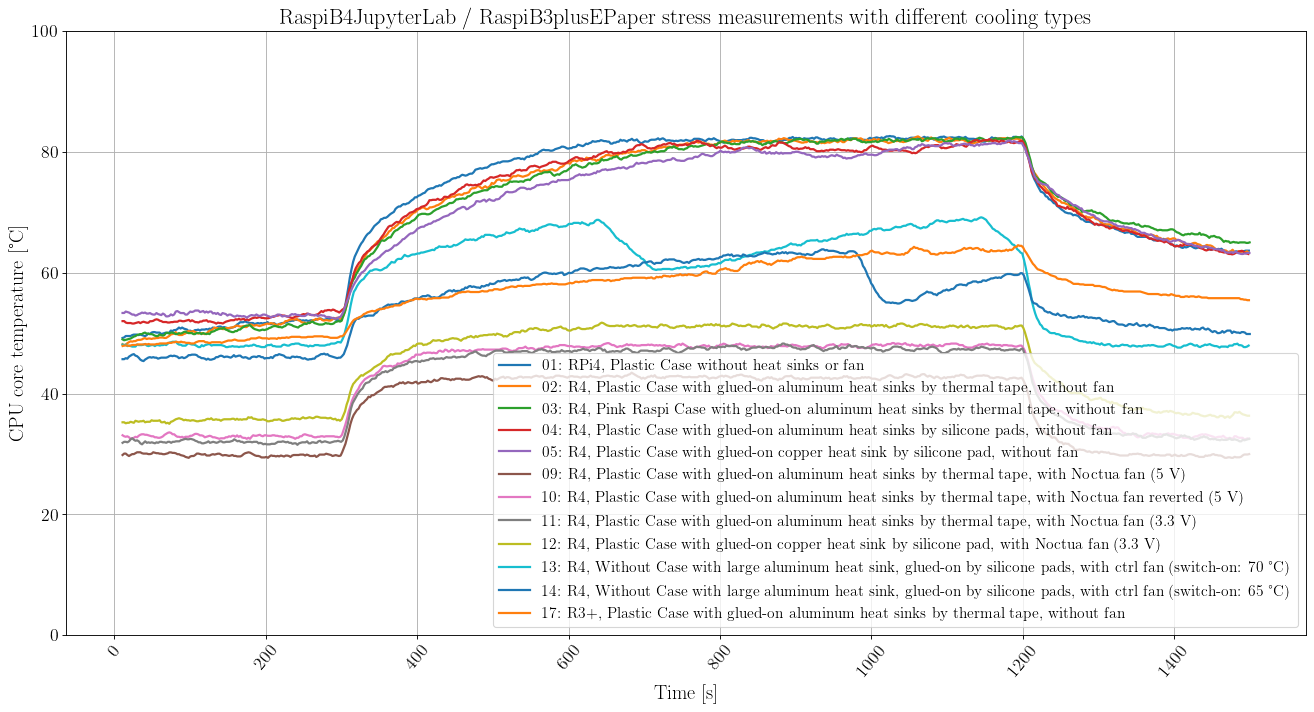

In [96]:
# figsize: a tuple (width, height) in inches
plt.figure(num=0, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
axes = plt.gca()

plt.title('RaspiB4JupyterLab / RaspiB3plusEPaper stress measurements with different cooling types')

for scen_IDs in df_measurement_configs['Scenario IDs']:
    _df_handle, _str_title, _str_filepath = get_data_and_meta_infos_for_plotting(scen_IDs, df_measurement_configs, dict_of_df_records, dict_of_filenames)
    
    if (not len(_df_handle) == 0) and \
        (scen_IDs != 'scen_id_06') and \
        (scen_IDs != 'scen_id_07') and \
        (scen_IDs != 'scen_id_08'):
        _str_label = scen_IDs.replace('scen_id_', '') + ': '+_str_title
        plt.plot(_df_handle['Time'], _df_handle['CPU Temperature'], '-', label=_str_label)

#plt.plot(df_12_woC_wHeatSinksAndCtrlFan5V_65C['Time'], df_12_woC_wHeatSinksAndCtrlFan5V_65C['Ambient Temperature'], '-', label='Ambient Temperature')

plt.xlabel('Time [s]')
plt.ylabel('CPU core temperature [°C]')

plt.ylim(0, 100)

plt.grid(True)

plt.setp(plt.gca().xaxis.get_majorticklabels(), 'rotation', 50)

plt.legend()

# Save plot to PNG and PDF
str_image_name = 'RaspiB4JupyterLab_RaspiB3plusEPaper_stress_measurement_all_scenarios_compared'
#plt.savefig(r'./data_files/' + str_image_name + '.png')
plt.savefig(r'./data_files/' + str_image_name + '.pdf')

plt.show()

### Scenario 01: RPi4, Plastic Case without heat sinks or fan

This is the plot of the temperature curve compared with the CPU frequency curve for the Raspberry Pi B4 with the cooling variant "passive cooling: without heat sinks or fan".

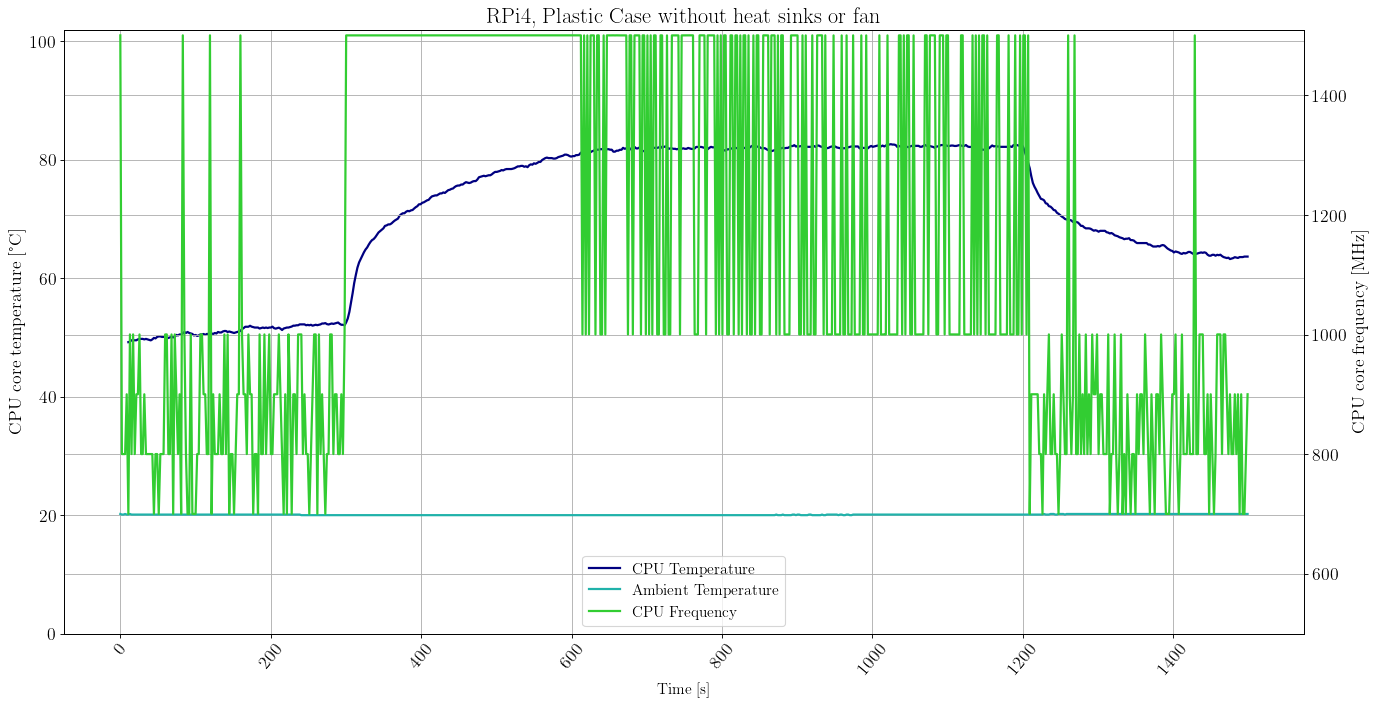

In [21]:
diagram_title_str = plot_single_measurement('scen_id_01')

In [23]:
section_title_str = 'Scenario 01: ' + diagram_title_str
print(section_title_str)

Scenario 01: RPi4, Plastic Case without heat sinks or fan


### Scenario 02: R4, Plastic Case with glued-on aluminum heat sinks by thermal tape, without fan

This is the plot of the temperature curve compared with the CPU frequency curve for the Raspberry Pi B4 with the cooling variant "glued-on heat sinks without fan". The thermal coupling between the CPU and the **aluminum** heat sink is made of double-sided **thermal tape**.

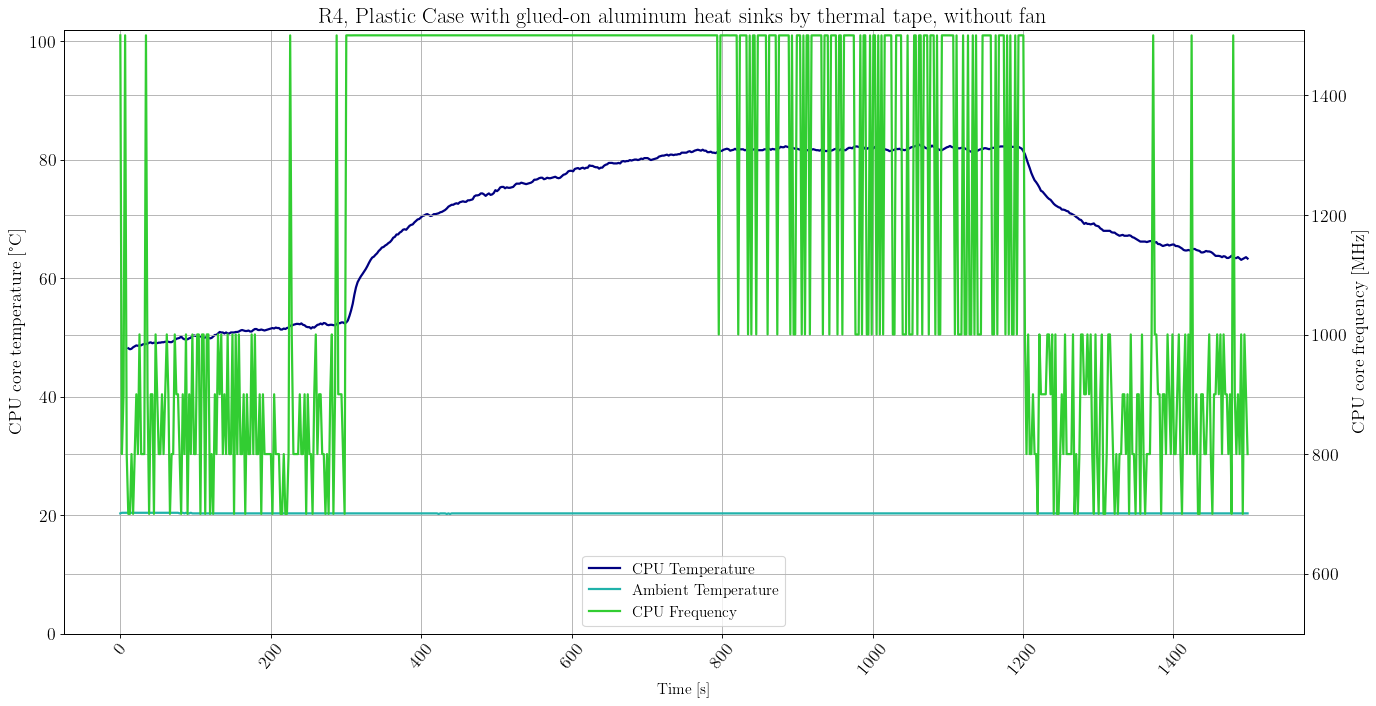

In [24]:
diagram_title_str = plot_single_measurement('scen_id_02')

In [25]:
section_title_str = 'Scenario 02: ' + diagram_title_str
print(section_title_str)

Scenario 02: R4, Plastic Case with glued-on aluminum heat sinks by thermal tape, without fan


### Scenario 04: R4, Plastic Case with glued-on aluminum heat sinks by silicone pads, without fan

This is the plot of the temperature curve compared with the CPU frequency curve for the Raspberry Pi B4 with the cooling variant "glued-on heat sinks without fan". The thermal coupling between the CPU and the **aluminum** heat sink is made of a **silicon pad**.

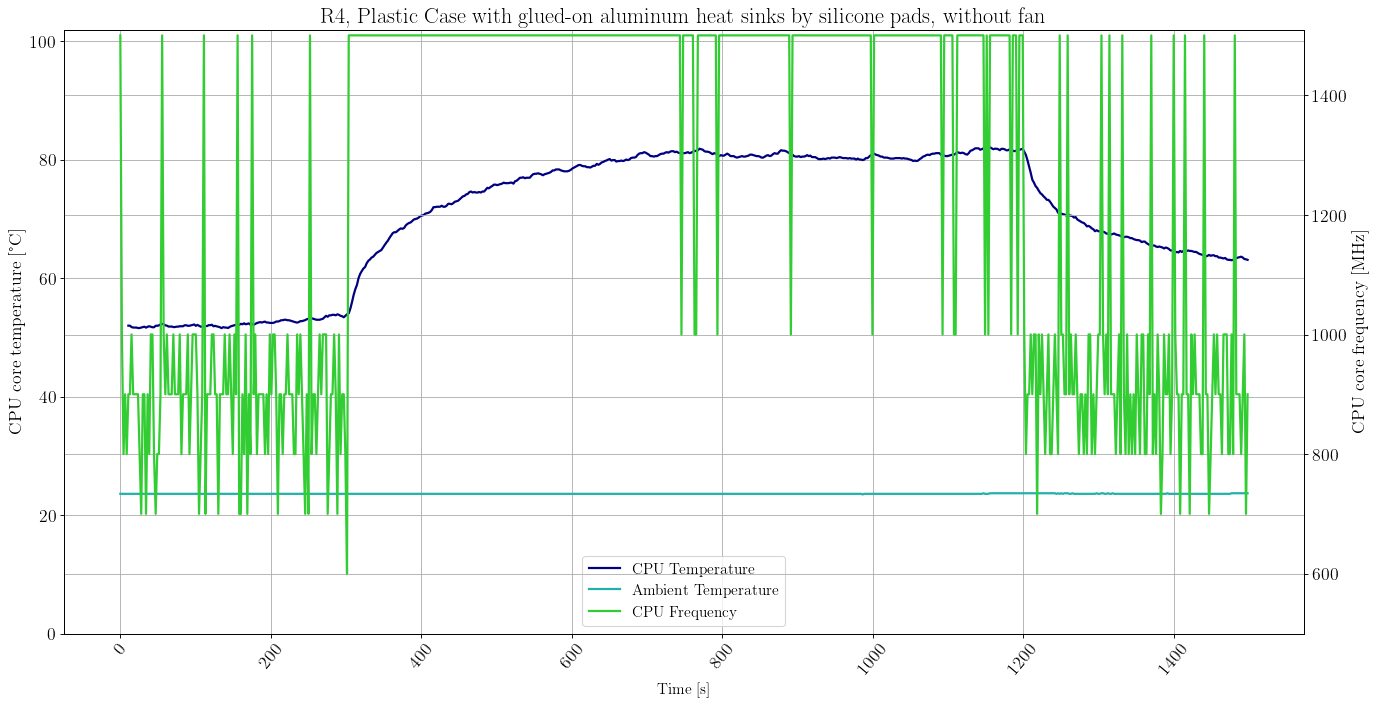

In [29]:
diagram_title_str = plot_single_measurement('scen_id_04')

In [30]:
section_title_str = 'Scenario 04: ' + diagram_title_str
print(section_title_str)

Scenario 04: R4, Plastic Case with glued-on aluminum heat sinks by silicone pads, without fan


### Scenario 05: R4, Plastic Case with glued-on copper heat sink by silicone pad, without fan

This is the plot of the temperature curve compared with the CPU frequency curve for the Raspberry Pi B4 with the cooling variant "glued-on heat sinks without fan". The thermal coupling between the CPU and the **copper** heat sink is made of a **silicon pad**.

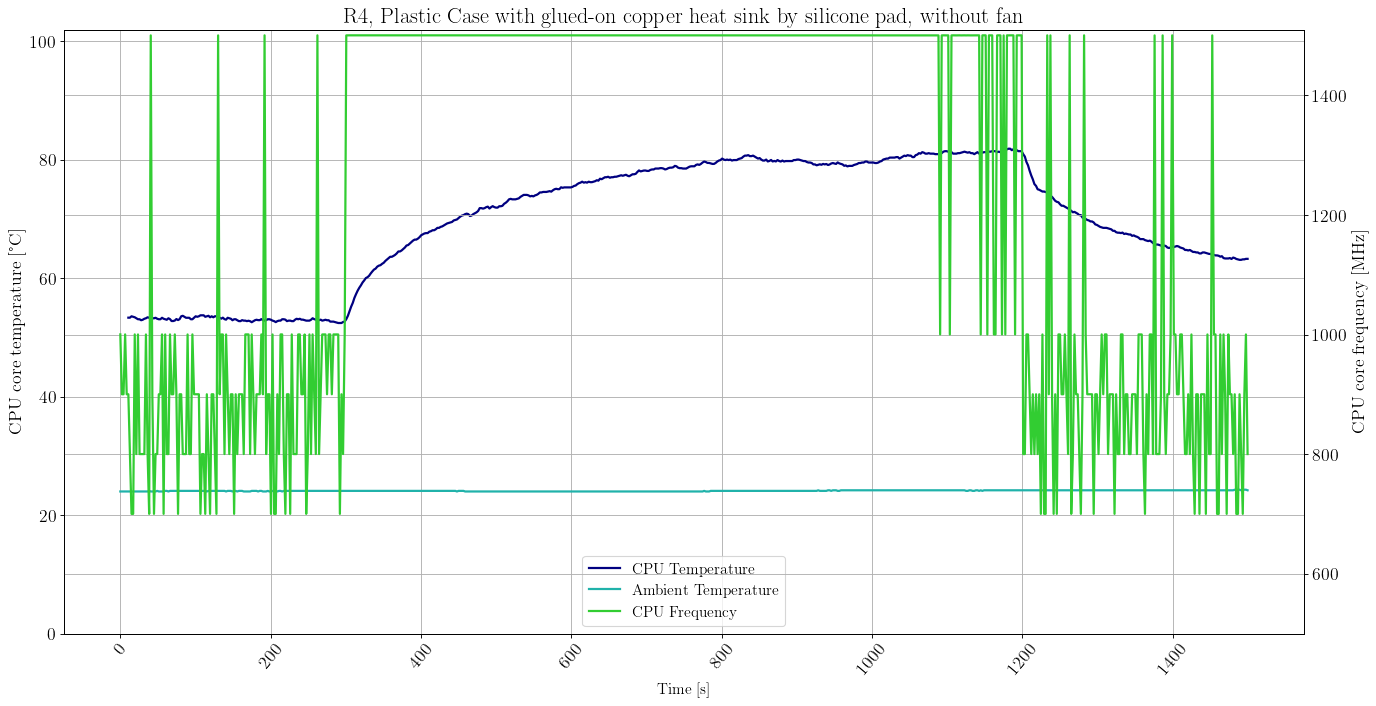

In [31]:
diagram_title_str = plot_single_measurement('scen_id_05')

In [32]:
section_title_str = 'Scenario 05: ' + diagram_title_str
print(section_title_str)

Scenario 05: R4, Plastic Case with glued-on copper heat sink by silicone pad, without fan


### Scenario 11: R4, Plastic Case with glued-on aluminum heat sinks by thermal tape, with Noctua fan (3.3 V)

This is the plot of the temperature curve compared with the CPU frequency curve for the Raspberry Pi B4 with the cooling variant "glued-on heat sinks with **Noctua fan** (driven by **3.3 V**)". The thermal coupling between the CPU and the **aluminum** heat sink is made of double-sided **thermal tape**.

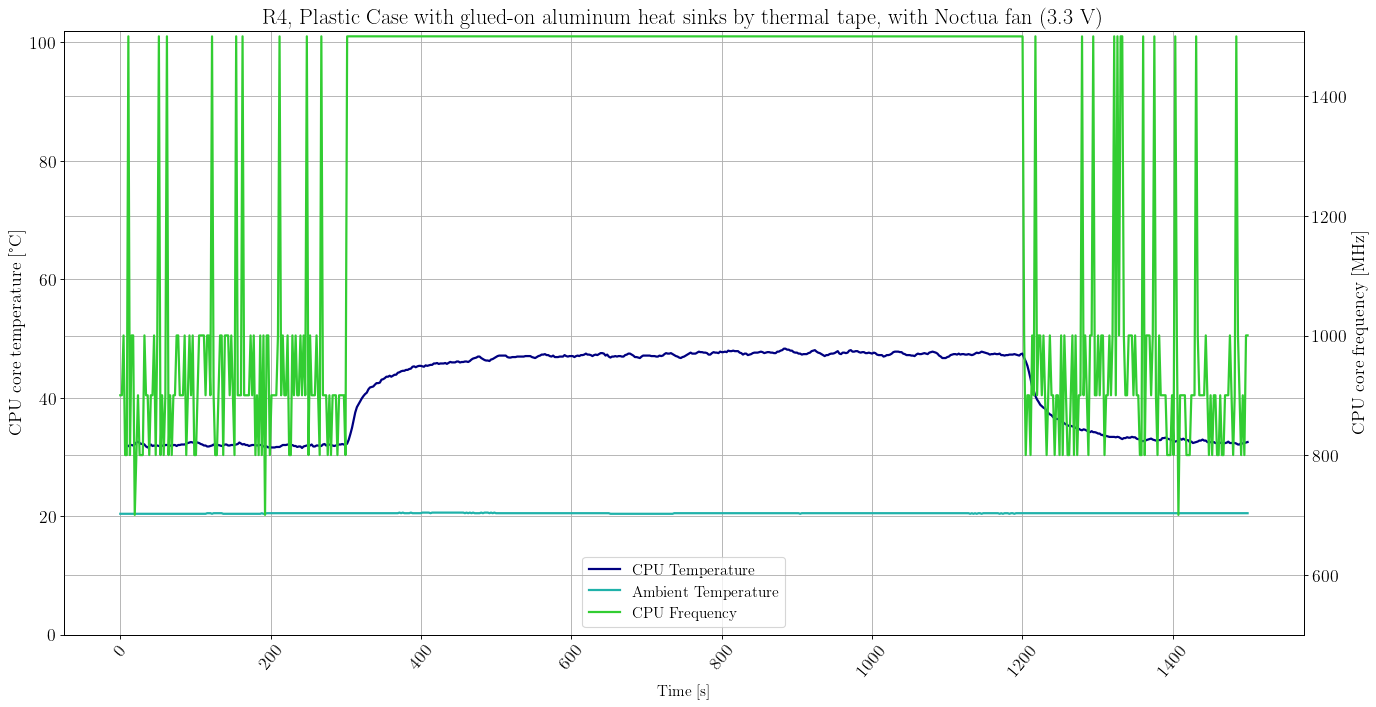

In [33]:
diagram_title_str = plot_single_measurement('scen_id_11')

In [34]:
section_title_str = 'Scenario 11: ' + diagram_title_str
print(section_title_str)

Scenario 11: R4, Plastic Case with glued-on aluminum heat sinks by thermal tape, with Noctua fan (3.3 V)


### Scenario 12: R4, Plastic Case with glued-on copper heat sink by silicone pad, with Noctua fan (3.3 V)

This is the plot of the temperature curve compared with the CPU frequency curve for the Raspberry Pi B4 with the cooling variant "glued-on heat sinks with **Noctua fan** (driven by **3.3 V**)". The thermal coupling between the CPU and the **copper** heat sink is made of a **silicon pad**.

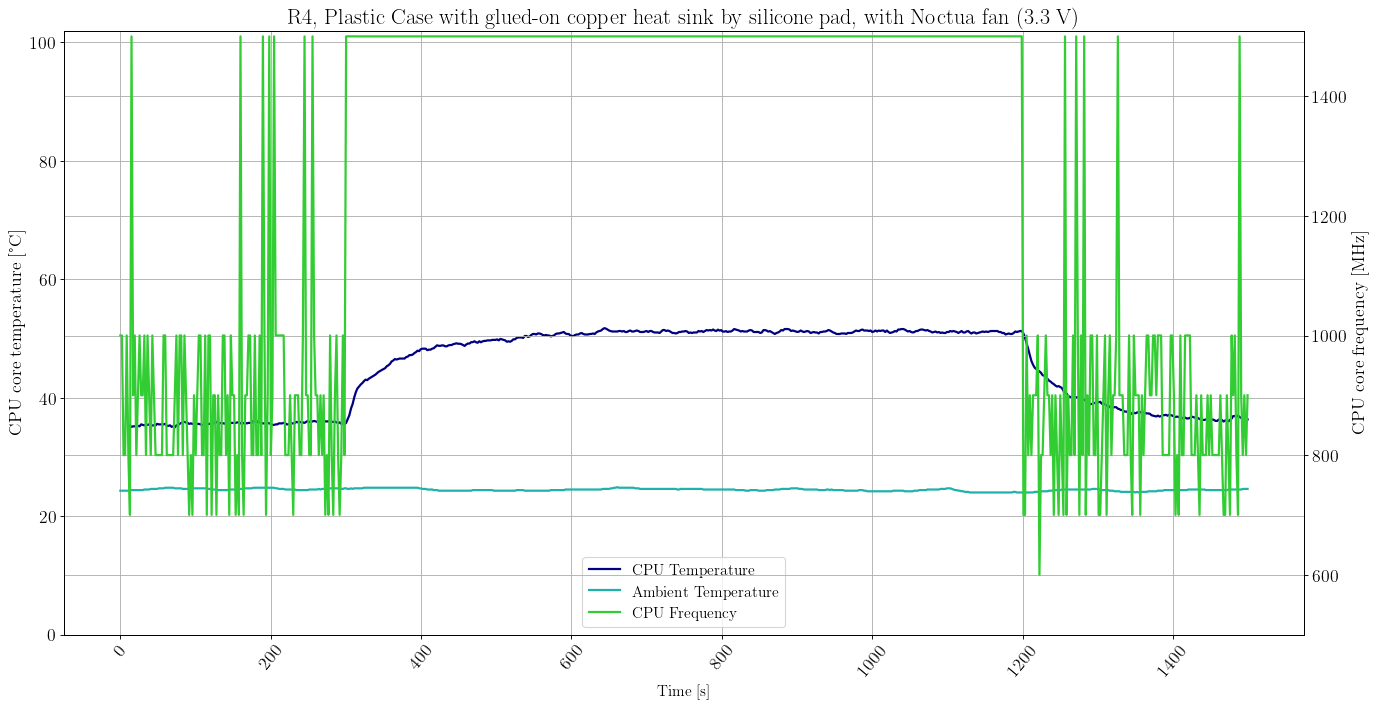

In [35]:
diagram_title_str = plot_single_measurement('scen_id_12')

In [37]:
section_title_str = 'Scenario 12: ' + diagram_title_str
print(section_title_str)

Scenario 12: R4, Plastic Case with glued-on copper heat sink by silicone pad, with Noctua fan (3.3 V)


### Scenario 14: R4, Without Case with large aluminum heat sink, glued-on by silicone pads, with ctrl fan (switch-on: 65 °C)

The following thermal images show the **Raspberry Pi 4B** in idle (1) state and under CPU full load (2). The images were taken with the thermal camera *Ti 480 Thermal Imager (Fluke)*:

![(1) Thermal image of the RPi 4B in idle state](images/thermal_images/RPi4_thermalImage_idleMode_wHeatSinkAndCtrlFan5V.jpg)  
(1) Thermal image of the RPi 4B in idle state

![(2) Thermal image of the RPi 3B+ under CPU full load](images/thermal_images/RPi4_thermalImage_heavyLoadMode_wHeatSinkAndCtrlFan5V.jpg)  
(2) Thermal image of the RPi 4B under CPU full load

This is the plot of the temperature curve compared with the CPU frequency curve for the Raspberry Pi B4 with the cooling variant "wo Case and one big heat sink with controlled fan (driven by 5 V and 65°C switch-on temperature)". The thermal couplings between the CPU, RAM and USB controller and the big **aluminum** heat sink are made of a **silicon pads**.

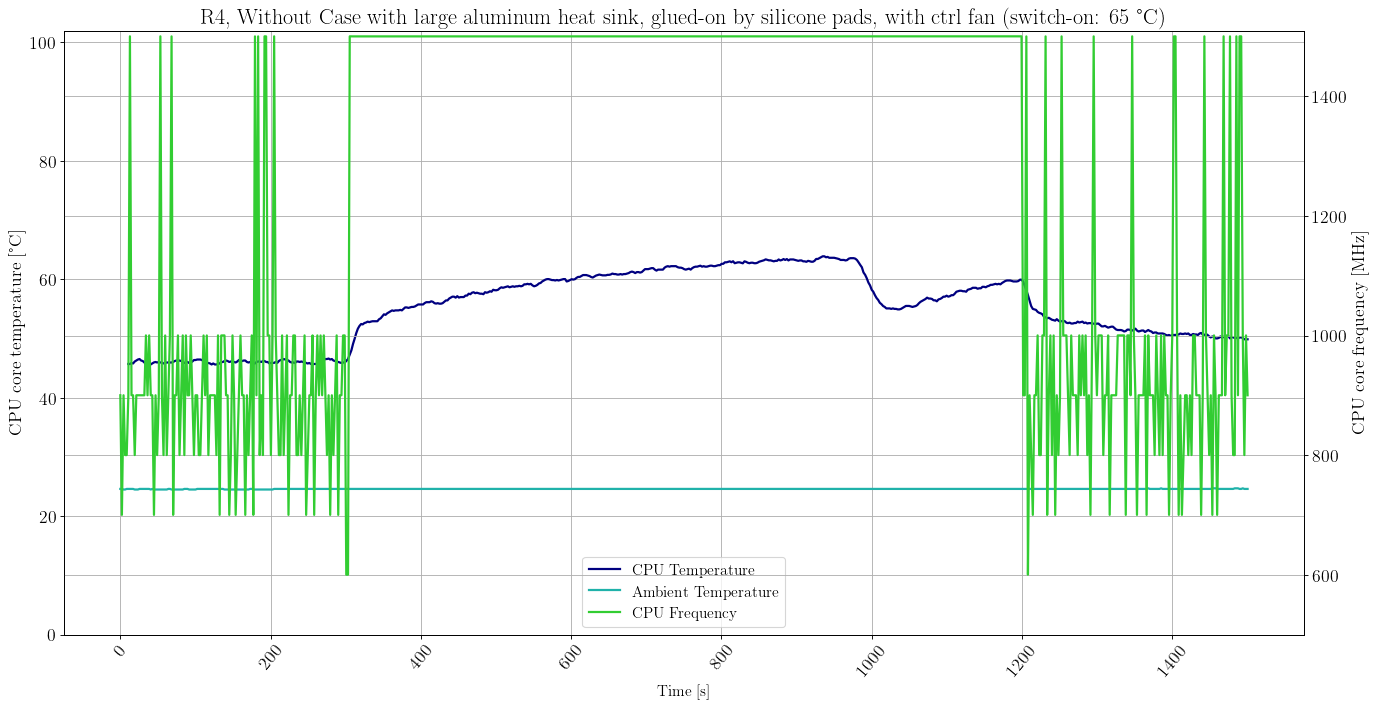

In [38]:
diagram_title_str = plot_single_measurement('scen_id_14')

In [39]:
section_title_str = 'Scenario 14: ' + diagram_title_str
print(section_title_str)

Scenario 14: R4, Without Case with large aluminum heat sink, glued-on by silicone pads, with ctrl fan (switch-on: 65 °C)


### Scenario 17: R3+, Plastic Case with glued-on aluminum heat sinks by thermal tape, without fan

The following thermal images show the **Raspberry Pi 3B+** in idle (1) state and under CPU full load (2). The images were taken with the thermal camera *Ti 480 Thermal Imager (Fluke)*:

![(1) Thermal image of the RPi 3B+ in idle state](images/thermal_images/RPi3Bplus_thermalImage_idleMode_c.jpg)  
(1) Thermal image of the RPi 3B+ in idle state

![(2) Thermal image of the RPi 3B+ under CPU full load](images/thermal_images/RPi3Bplus_thermalImage_heavyLoadMode_c.jpg)  
(2) Thermal image of the RPi 3B+ under CPU full load

This is the plot of the temperature curve compared with the CPU frequency curve for the Raspberry Pi 3B+ with the cooling variant "glued-on heat sinks without fan".

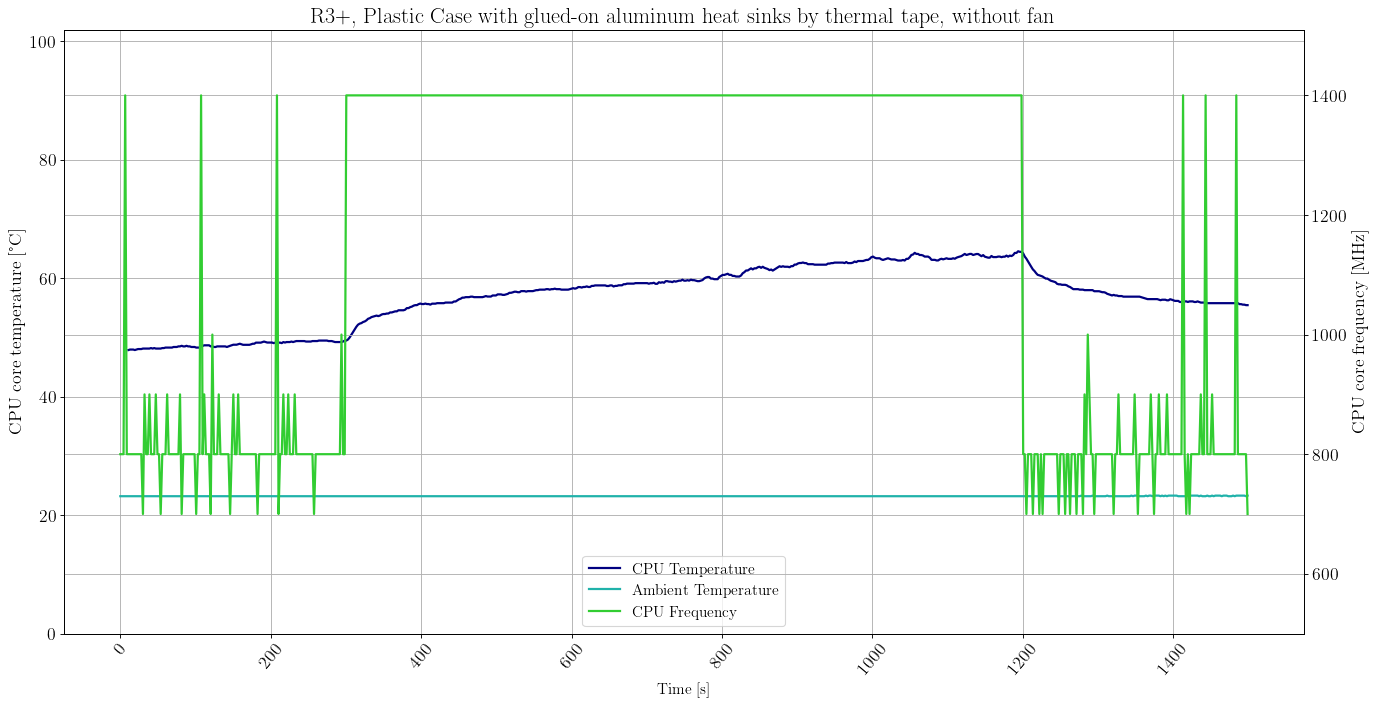

In [19]:
diagram_title_str = plot_single_measurement('scen_id_17')

In [20]:
section_title_str = 'Scenario 17: ' + diagram_title_str
print(section_title_str)

Scenario 17: R3+, Plastic Case with glued-on aluminum heat sinks by thermal tape, without fan
